In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import sklearn
from scipy import stats

import time

In [124]:
train_data_x=[]
train_data_y=[]
test_data_x=[]
test_data_y=[]
d=28*28
n_train=6000
n_test = 750

for lettre in "ABC" :
    for image_path in glob.glob("./data/train/"+lettre+"/*.png"):
        train_data_x.append(mpimg.imread(image_path))
        if lettre=="A" :
            train_data_y.append(1)
        else :
            train_data_y.append(-1) 
    for image_path in glob.glob("./data/test/"+lettre+"/*.png"):
        test_data_x.append(mpimg.imread(image_path))
        if lettre=="A" :
            test_data_y.append(1)
        else :
            test_data_y.append(-1)

In [125]:
X_train=np.reshape(train_data_x,(n_train,d)) 
Y_train=np.array(train_data_y)
X_test=np.reshape(test_data_x,(n_test,d)) 
Y_test=np.array(test_data_y)

randperm = np.random.permutation(X_train.shape[0])
X_train = X_train[randperm,:]
Y_train = Y_train[randperm]

n_small = n_train #peut être utile de mettre des petites valeurs pour que les calculs ne prennent pas trop de temps
X_train=X_train[:n_small]
Y_train = Y_train[:n_small]

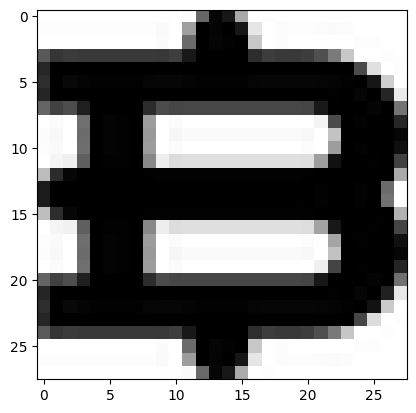

This picture has the label B or C


In [145]:
i = np.random.randint(n_small)
plt.imshow(np.reshape(X_train[i],(28,28)), cmap='binary')
plt.show()
if Y_train[i]==1 : tag = "A" 
else : tag = "B or C"
print("This picture has the label " + tag)

Logistic regression
-----------------------------------


In [163]:
def L(s,y):  return 1/s.shape[0] * sum( np.log( 1 + np.exp(-s*y) ) )
def emp_risk_lr(w): return L((X_train@w),Y_train);
def test_risk_lr(w): return L((X_test@w),Y_test);

In [164]:
def theta(v): return 1 / (1+np.exp(-np.clip(v,-30,30)))
def gradL(s,r): return - 1/s.shape[0] * r * theta(-s * r)
def grad_lr(w): return X_train.transpose().dot( gradL((X_train@w),Y_train) )

In [165]:
T_lr_gd = 100
emp_risks_lr_gd = np.zeros(T_lr_gd)
test_risks_lr_gd = np.zeros(T_lr_gd)
theta_lr_gd = np.zeros(X_train.shape[1])
gamma = 0.069
for t in range(T_lr_gd):
    emp_risks_lr_gd[t] = emp_risk_lr(theta_lr_gd)
    test_risks_lr_gd[t] = test_risk_lr(theta_lr_gd)
    theta_lr_gd -= gamma*grad_lr(theta_lr_gd)

In [166]:
def grad_sto_lr(w,i):
    return -X_train[i%n_small]*Y_train[i%n_small]*theta(-(X_train[i%n_small]@w)*Y_train[i%n_small])

In [168]:
T_lr_sgd = T_gd*n_small
T_lr_test_period = 1000
emp_risks_lr_sgd = np.zeros(int(T_lr_sgd/T_lr_test_period)+1)
test_risks_lr_sgd = np.zeros(int(T_lr_sgd/T_lr_test_period)+1)
theta_lr_sgd = np.zeros(X_train.shape[1])
gamma = 0.00005
for t in range(T_lr_sgd):
    if t%T_lr_test_period == 0:
        emp_risks_lr_sgd[int(t/T_lr_test_period)] = emp_risk_lr(theta_lr_sgd)
        test_risks_lr_sgd[int(t/T_lr_test_period)] = test_risk_lr(theta_lr_sgd)    
    theta_lr_sgd -= gamma*grad_sto_lr(theta_lr_sgd,t)

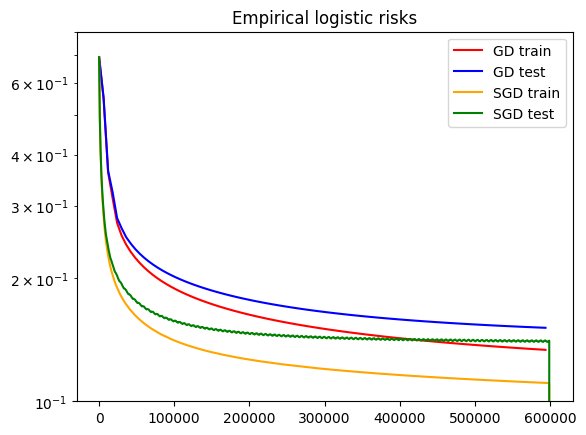

In [169]:
ts_lr_gd = [n_small*t for t in range(T_lr_gd)]
ts_lr_sgd = [t*T_lr_test_period for t in range(int(T_lr_sgd/T_lr_test_period)+1)]
plt.semilogy(ts_lr_gd, emp_risks_lr_gd, 'red', label='GD train')
plt.semilogy(ts_lr_gd, test_risks_lr_gd, 'blue', label='GD test')
plt.semilogy(ts_lr_sgd, emp_risks_lr_sgd, 'orange', label = 'SGD train')
plt.semilogy(ts_lr_sgd, test_risks_lr_sgd, 'green', label = 'SGD test')
plt.legend()
plt.ylim(10**(-1),0.8)
plt.title('Empirical logistic risks')
plt.show()

Linear regression
-----------------------------------




In [170]:
X_train_lin = np.ones((X_train.shape[0],X_train.shape[1]+1))
X_train_lin[:,1:] = X_train
X_test_lin = np.ones((X_test.shape[0],X_test.shape[1]+1))
X_test_lin[:,1:] = X_test

In [171]:
def emp_risk(theta):
    return np.linalg.norm(Y_train-X_train_lin@theta)**2/n_small

def test_risk(theta):
    return np.linalg.norm(Y_test-X_test_lin@theta)**2/n_test

In [172]:
def grad_emp_risk(theta):
    return -2*X_train_lin.T@(Y_train-X_train_lin@theta)/n_small

In [173]:
T_gd = 100
emp_risks_gd = np.zeros(T_gd)
test_risks_gd = np.zeros(T_gd)
theta_gd = np.zeros(X_train_lin.shape[1])
gamma = 0.003
for t in range(T_gd):
    emp_risks_gd[t] = emp_risk(theta_gd)
    test_risks_gd[t] = test_risk(theta_gd)
    theta_gd -= gamma*grad_emp_risk(theta_gd)

In [174]:
def grad_sto(theta,i):
    return -2*(Y_train[i%n_small]-X_train_lin[i%n_small]@theta)*X_train_lin[i%n_small]

In [175]:
T_sgd = T_gd*n_small
T_test_period = 500
emp_risks_sgd = np.zeros(int(T_sgd/T_test_period)+1)
test_risks_sgd = np.zeros(int(T_sgd/T_test_period)+1)
theta_sgd = np.zeros(X_train_lin.shape[1])
gamma = 0.00005
for t in range(T_sgd):
    if t%T_test_period == 0:
        emp_risks_sgd[int(t/T_test_period)] = emp_risk(theta_sgd)
        test_risks_sgd[int(t/T_test_period)] = test_risk(theta_sgd)    
    theta_sgd -= gamma*grad_sto(theta_sgd,t)

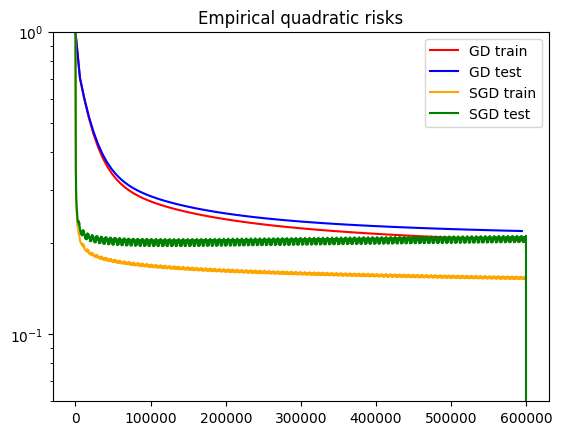

In [176]:
ts_gd = [n_small*t for t in range(T_gd)]
ts_sgd = [t*T_test_period for t in range(int(T_sgd/T_test_period)+1)]
plt.semilogy(ts_gd, emp_risks_gd, 'red', label='GD train')
plt.semilogy(ts_gd, test_risks_gd, 'blue', label='GD test')
plt.semilogy(ts_sgd, emp_risks_sgd, 'orange', label = 'SGD train')
plt.semilogy(ts_sgd, test_risks_sgd, 'green', label = 'SGD test')
plt.legend()
plt.ylim(6*10**(-2),1)
plt.title('Empirical quadratic risks')
plt.show()

K-NN Classification
-----------------------------------


In [177]:
from scipy.spatial.distance import cdist

dist_test_train = cdist(X_test, X_train, 'euclidean')
dist_train_train = cdist(X_train, X_train, 'euclidean')
ind_dist_test_train = np.argsort(dist_test_train, axis=1)
ind_dist_train_train = np.argsort(dist_train_train, axis=1)

In [178]:
a=np.matrix('1 3 2 ; 6 5 4 ; 8 7 9 ')
print(a)
print(np.argsort(a, axis=1))

[[1 3 2]
 [6 5 4]
 [8 7 9]]
[[0 2 1]
 [2 1 0]
 [1 0 2]]


In [179]:
from sklearn.metrics import confusion_matrix

def get_confusion(ind_dist_test_train, Y_test, Y_train, k):
    P = np.squeeze(Y_train[ind_dist_test_train[:, :k]])
    if k==1:
        Y_hat = P
    else:
        Y_hat, _ = stats.mode(P, axis=1,keepdims=True)
    return confusion_matrix(Y_test, Y_hat)


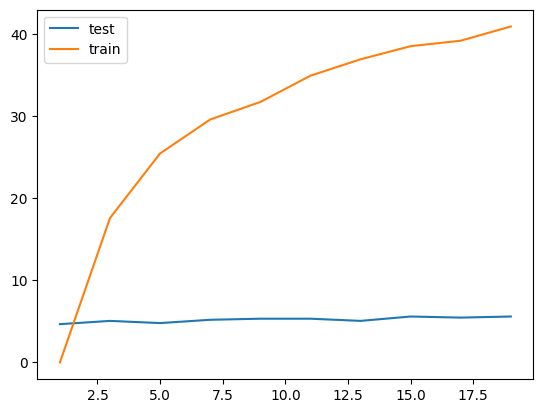

In [180]:
K_max = 20
err_test = []
err_train = []
# Faire la boucle uniquement sur les nombres impairs
for k in np.arange(1,K_max,2):
    conf_test = get_confusion(ind_dist_test_train, Y_test, Y_train, k)
    err_test.append((100.*(n_test-np.trace(conf_test))) / n_test)
    conf_train = get_confusion(ind_dist_train_train, Y_train, Y_train, k)
    err_train.append((100.*(n_train-np.trace(conf_train))) / n_test)

plt.plot(np.arange(1,K_max,2),err_test, label='test')
plt.plot(np.arange(1,K_max,2),err_train, label='train')
plt.legend()

In [181]:
n_fold = 5
K_max = 20
K_range = np.arange(1, K_max, 2)
# Création des différents folds
ind_fold = np.floor(n_fold*np.random.rand(n_small))
err_val_fold = np.zeros([n_fold, len(K_range)])

for f in range(n_fold):
    X_train_cv = X_train[ind_fold != f, :]
    Y_train_cv = Y_train[ind_fold != f]
    X_val_cv = X_train[ind_fold == f, :]
    Y_val_cv = Y_train[ind_fold == f]
    n_val = np.size(Y_val_cv)
    # Preprocessing
    dist_val_train = cdist(X_val_cv, X_train_cv, 'euclidean')
    ind_dist_val_train = np.argsort(dist_val_train, axis=1)
    for i, k in enumerate(K_range):
        conf_val = get_confusion(ind_dist_val_train, Y_val_cv, Y_train_cv, k)
        err_val_fold[f, i] = (100. *(n_val-np.trace(conf_val))) / n_val

# Resultat de la validation croisée 
average_err_on_folds = np.mean(err_val_fold, axis=0)
k_select = K_range[np.argmin(average_err_on_folds)]
print('Erreur moyenne sur les sous ensembles:\n')
print(average_err_on_folds)
print("\n******************\n k choisi = %d \n******************\n" % k_select)


Erreur moyenne sur les sous ensembles:

[5.02423633 4.44724429 4.5621389  4.69629732 4.8990034  5.01643382
 5.21970114 5.22060285 5.33562189 5.36569915]

******************
 k choisi = 3 
******************



Question 3
-----------------------------------


a)

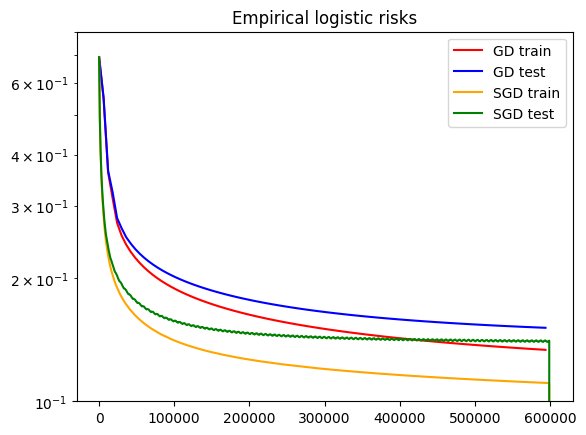

In [182]:
ts_lr_gd = [n_small*t for t in range(T_lr_gd)]
ts_lr_sgd = [t*T_lr_test_period for t in range(int(T_lr_sgd/T_lr_test_period)+1)]
plt.semilogy(ts_lr_gd, emp_risks_lr_gd, 'red', label='GD train')
plt.semilogy(ts_lr_gd, test_risks_lr_gd, 'blue', label='GD test')
plt.semilogy(ts_lr_sgd, emp_risks_lr_sgd, 'orange', label = 'SGD train')
plt.semilogy(ts_lr_sgd, test_risks_lr_sgd, 'green', label = 'SGD test')
plt.legend()
plt.ylim(10**(-1),0.8)
plt.title('Empirical logistic risks')
plt.show()

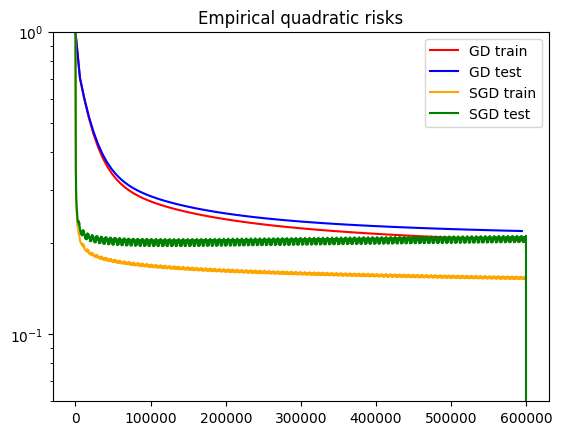

In [183]:
ts_gd = [n_small*t for t in range(T_gd)]
ts_sgd = [t*T_test_period for t in range(int(T_sgd/T_test_period)+1)]
plt.semilogy(ts_gd, emp_risks_gd, 'red', label='GD train')
plt.semilogy(ts_gd, test_risks_gd, 'blue', label='GD test')
plt.semilogy(ts_sgd, emp_risks_sgd, 'orange', label = 'SGD train')
plt.semilogy(ts_sgd, test_risks_sgd, 'green', label = 'SGD test')
plt.legend()
plt.ylim(6*10**(-2),1)
plt.title('Empirical quadratic risks')
plt.show()

b)


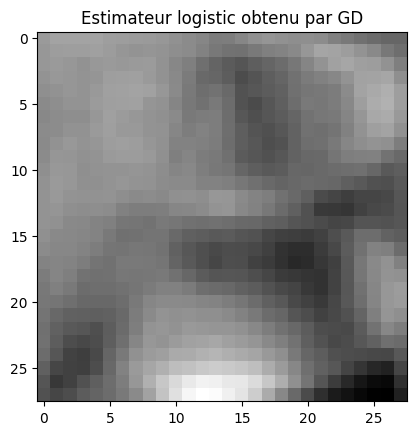

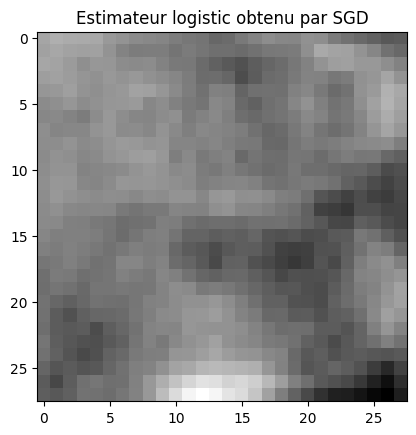

In [184]:
plt.imshow(np.reshape(theta_lr_gd,(28,28)), cmap='binary')
plt.title("Estimateur logistic obtenu par GD")
plt.show()
plt.imshow(np.reshape(theta_lr_sgd,(28,28)), cmap='binary')
plt.title("Estimateur logistic obtenu par SGD")
plt.show()

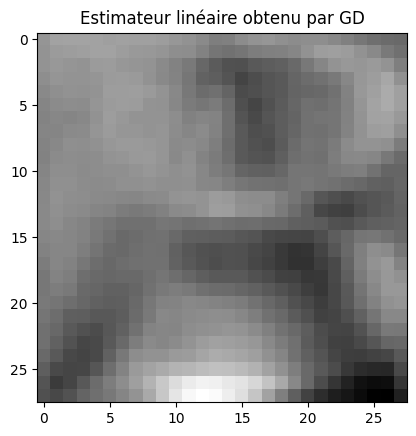

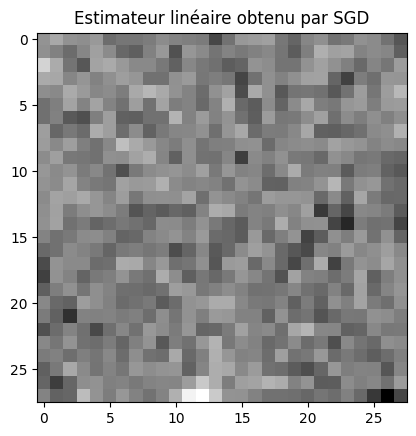

In [185]:
plt.imshow(np.reshape((theta_gd[1:]+theta_gd[0]),(28,28)), cmap='binary')
plt.title("Estimateur linéaire obtenu par GD")
plt.show()
plt.imshow(np.reshape((theta_sgd[1:]+theta_sgd[0]),(28,28)), cmap='binary')
plt.title("Estimateur linéaire obtenu par SGD")
plt.show()

c)


In [226]:
theta_lr_sgd = np.zeros(X_train.shape[1])
sums_logi=[0 for i in range(4)]
gamma = 0.00005
for t in range(10000):  
    theta_lr_sgd -= gamma*grad_sto_lr(theta_lr_sgd,t)
    for i in range(4):
        if np.log10(t+1)<=i+1 :
            sums_logi[i]+=theta_lr_sgd/(10**(i+1))

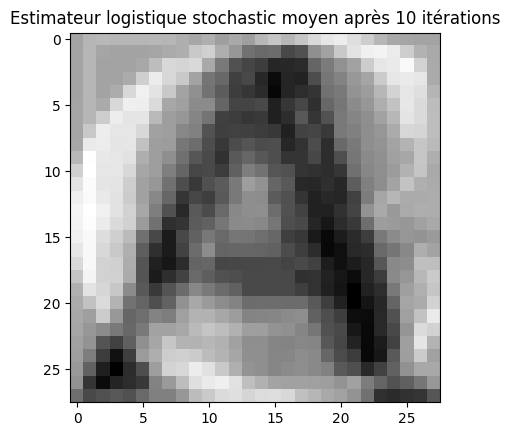

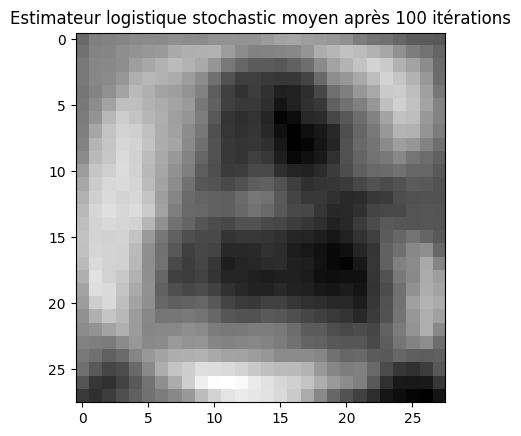

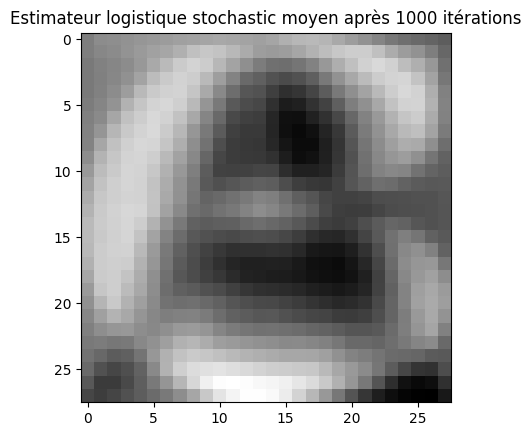

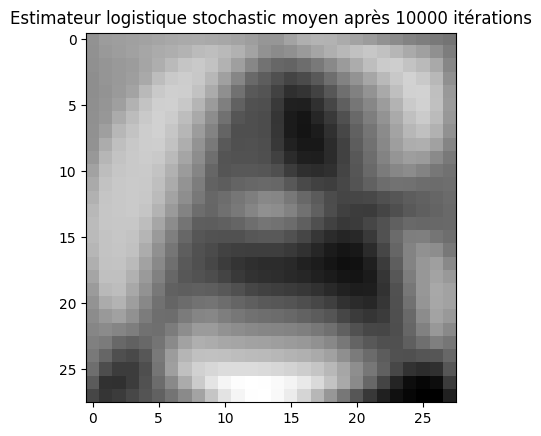

In [230]:
for i in range(4) :
    plt.imshow(np.reshape((sums_logi[i]),(28,28)), cmap='binary')
    plt.title("Estimateur logistique stochastic moyen après "+str(10**(i+1))+" itérations")
    plt.show()

In [231]:
theta_sgd = np.zeros(X_train_lin.shape[1])
sums_lin=[0 for i in range(4)]
gamma = 0.00005
for t in range(1,10000):  
    theta_sgd -= gamma*grad_sto(theta_sgd,t)
    for i in range(4):
        if np.log10(t)<=i+1 :
            sums_lin[i]+=theta_sgd/(10**(i+1))

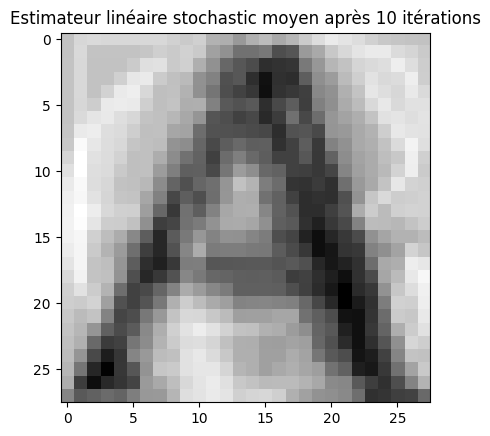

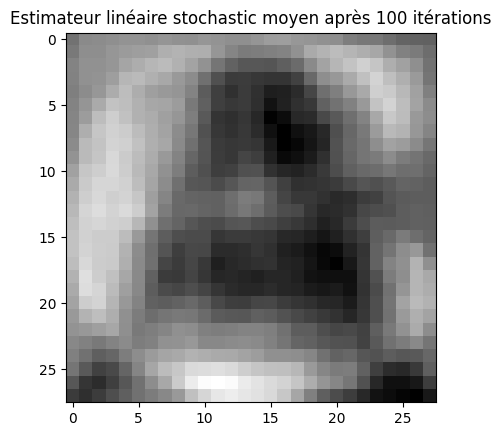

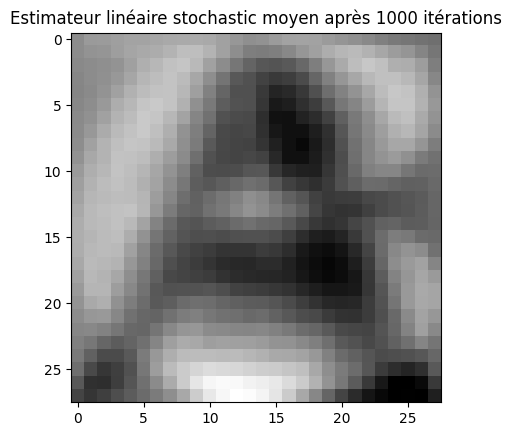

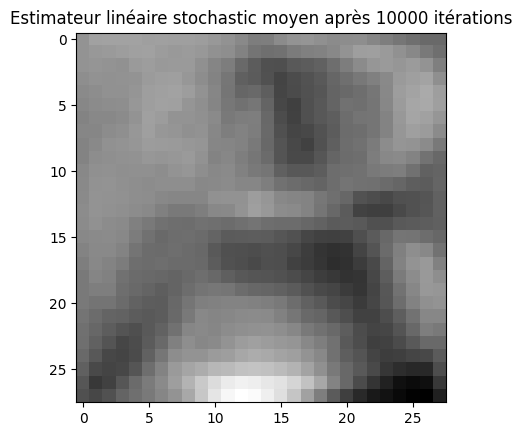

In [232]:
for i in range(4) :
    plt.imshow(np.reshape((sums_lin[i][1:]+sums_lin[i][0]),(28,28)), cmap='binary')
    plt.title("Estimateur linéaire stochastic moyen après "+str(10**(i+1))+" itérations")
    plt.show()